In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
import re

In [2]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Load the data

In [307]:
data_dir = os.path.abspath('../data')
data_path = os.path.join(data_dir, 'dfA_300s.hdf')

In [308]:
raw_input_df = pd.read_hdf(data_path)

In [309]:
raw_input_df

,A_additional_power,A_dishwasher_power,A_exp_power,A_hp_power,A_total_cons_power,A_sauna_power,A_stove_power,A_washing_machine_power
2017-04-01 00:00:00,30.0,0.0,0.0,750.0,1050.0,0.0,0.0,0.0
2017-04-01 00:05:00,60.0,0.0,0.0,720.0,1110.0,0.0,0.0,0.0
2017-04-01 00:10:00,90.0,0.0,0.0,730.0,1130.0,0.0,0.0,0.0
2017-04-01 00:15:00,90.0,0.0,0.0,720.0,1125.0,0.0,0.0,0.0
2017-04-01 00:20:00,40.0,0.0,0.0,720.0,1080.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2018-10-29 23:40:00,0.0,0.0,0.0,100.0,490.0,0.0,0.0,0.0
2018-10-29 23:45:00,15.0,0.0,0.0,525.0,900.0,0.0,0.0,0.0
2018-10-29 23:50:00,0.0,0.0,0.0,1640.0,2020.0,0.0,0.0,0.0
2018-10-29 23:55:00,15.0,0.0,0.0,600.0,930.0,0.0,0.0,0.0


In [310]:
column_mapping = {}
for c in raw_input_df.columns:
    if c in column_mapping:
        continue
    m = re.match(r'^[A-Z]_(\w+)$', c)
    if m is None:
        raise RuntimeError('Unsupported column name format {}. You will have to map the column manually.'.format(c))
    if m[1] == 'prod_power':
        column_mapping[c] = 'exp_power'
    else:
        column_mapping[c] = m[1]
input_df = raw_input_df.rename(columns=column_mapping)
input_df.columns

Index(['additional_power', 'dishwasher_power', 'exp_power', 'hp_power',
       'total_cons_power', 'sauna_power', 'stove_power',
       'washing_machine_power'],
      dtype='object')

In [392]:
appliance_column = 'dishwasher_power'
test_day = '2017-05-21'

In [393]:
all_appliance_columns = sorted({'dishwasher_power', 'washing_machine_power', 'tumble_dryer_power'} & set(input_df.columns))
all_appliance_columns

['dishwasher_power', 'washing_machine_power']

# Vizualize a day of data

In [394]:
test_day_df = input_df[test_day]

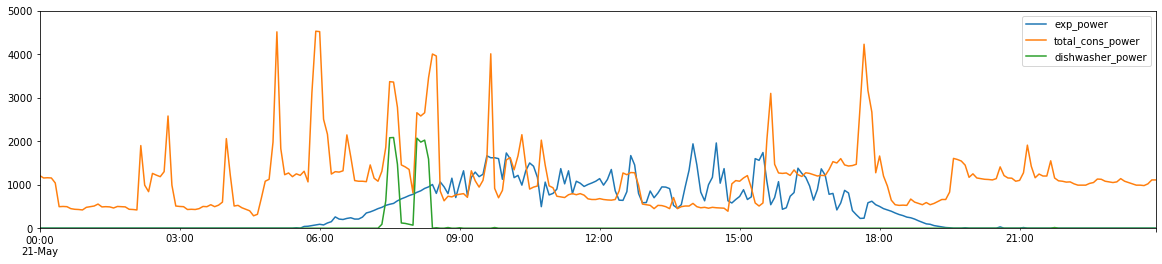

In [395]:
test_day_df.plot(y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))

In [315]:
appliance_series = test_day_df[appliance_column]
print(len(appliance_series))

288


# Detect appliance active areas
Figure out how to detect the rough regions in time when appliances are used

## Experiment

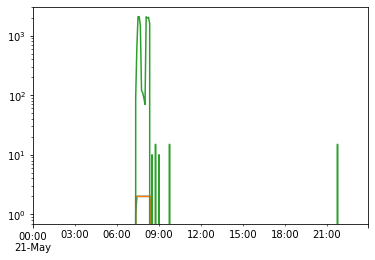

In [316]:
window_size = 2

rolling_series = (appliance_series > 20).rolling(window_size, center=True).sum()
active_areas_series = (rolling_series > 0)

plt.figure()
plt.yscale('log')
rolling_series.plot()
(active_areas_series * window_size).plot()
appliance_series.plot()
plt.show()

In [317]:
temp = active_areas_series.astype('int8').diff()
active_areas = list(grouper(temp.index[(temp == 1) | (temp == -1)], n=2))
active_areas

[(Timestamp('2017-05-21 07:20:00'), Timestamp('2017-05-21 08:30:00'))]

## Implement

In [318]:
def narrow_active_area(active_mask, active_area):
    start, end = active_area
    active_mask = active_mask[start:end]
    return active_mask[active_mask == True].index[0], active_mask[active_mask == True].index[-1]

# TODO The returned areas could be made narrower (they currently have some zeros at the start and end)
def detect_active_areas(input_series, window_size = 12, greater_than=0, narrow=True):
    active_mask = input_series > greater_than
    temp = active_mask.rolling(window_size, center=True).sum()
    temp = temp > 0
    temp = temp.astype('int8').diff()
    areas = grouper(temp.index[(temp == 1) | (temp == -1)], n=2)
    if not narrow:
        return list(areas)
    areas = (narrow_active_area(active_mask, a) for a in areas)
    areas = ((a, b) for a, b in areas if a != b)
    return list(areas)

## Test

In [319]:
detect_active_areas(appliance_series)

[(Timestamp('2017-05-21 07:20:00'), Timestamp('2017-05-21 09:45:00'))]

In [320]:
detect_active_areas(appliance_series, narrow=False)

[(Timestamp('2017-05-21 06:55:00'), Timestamp('2017-05-21 10:20:00')),
 (Timestamp('2017-05-21 21:20:00'), Timestamp('2017-05-21 22:20:00'))]

(Timestamp('2017-05-21 07:20:00', freq='300S'), Timestamp('2017-05-21 08:20:00', freq='300S'))


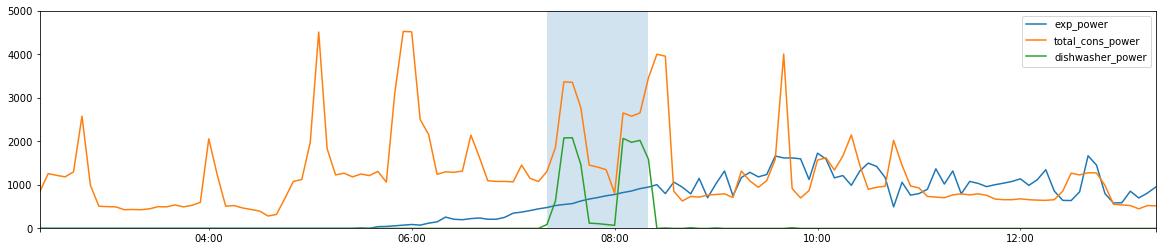

In [321]:
active_area = random.choice(detect_active_areas(appliance_series, greater_than=20))
print(active_area)
preview_area = (active_area[0] - pd.Timedelta(5, 'h'), active_area[1] + pd.Timedelta(5, 'h'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)

# Analyze appliance usage

In [322]:
all_appliance_active_areas = detect_active_areas(input_df[appliance_column], window_size=2, greater_than=20)
print("Appliance used {} times in {} days".format(len(all_appliance_active_areas), (input_df.index[-1] - input_df.index[0]).days))

Appliance used 232 times in 577 days


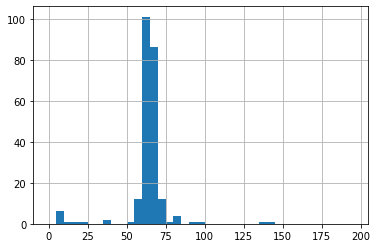

In [323]:
durations_series = pd.Series(b - a for a, b in all_appliance_active_areas)
durations_series.astype('timedelta64[m]').hist(bins=range(0, 200, 5))

In [324]:
durations_series.median()

Timedelta('0 days 01:00:00')

In [325]:
appliance_active_mask = np.logical_or.reduce(list((input_df.index >= a) & (input_df.index <= b) for a, b in all_appliance_active_areas))
print("Appliance active {:.2f}% of the time".format(100 * appliance_active_mask.sum() / len(input_df)))

Appliance active 1.85% of the time


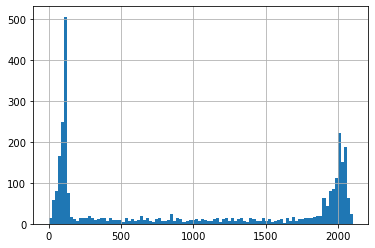

In [326]:
input_df[appliance_active_mask][appliance_column].hist(bins=100)

# Look at time between two washes

## Single example

In [327]:
active_area = next((a, b) for a, b in all_appliance_active_areas if a > pd.Timestamp('2018-01-06'))
print(active_area)
next_active_area = next((a, b) for a, b in all_appliance_active_areas if a > active_area[1])
print(next_active_area)

(Timestamp('2018-01-06 15:25:00', freq='300S'), Timestamp('2018-01-06 16:30:00', freq='300S'))
(Timestamp('2018-01-07 09:25:00', freq='300S'), Timestamp('2018-01-07 09:30:00', freq='300S'))


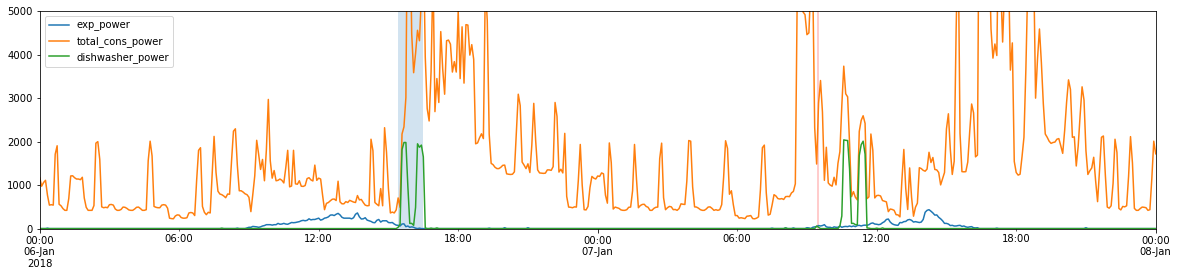

In [328]:
preview_area = (active_area[0].floor('d'), active_area[0].ceil('d') + pd.Timedelta(1, 'd'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)
p.axvspan(next_active_area[0], next_active_area[1], alpha=0.2, facecolor='red')

In [329]:
print(next_active_area[0] - active_area[1])

0 days 16:55:00


## Same for all washes

In [330]:
temp = (x for a in all_appliance_active_areas for x in a)
next(temp)
washes_df = pd.DataFrame(data={
    'start': (a for a, b in all_appliance_active_areas[:-1]),
    'end': (b for a, b in all_appliance_active_areas[:-1]),
    'trailing_gap': (b - a for a, b in grouper(temp, n=2) if b is not None),
})
print("Found {} gaps between {} washes".format(len(washes_df), len(all_appliance_active_areas)))

Found 231 gaps between 232 washes


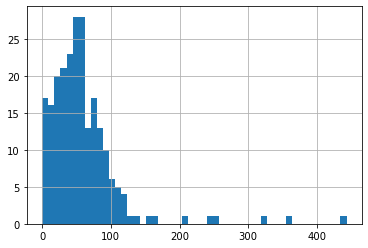

In [331]:
washes_df['trailing_gap'].astype('timedelta64[h]').hist(bins=50)

In [332]:
print(washes_df.trailing_gap.min())
print(washes_df.trailing_gap.median())
print(washes_df.trailing_gap.max())

0 days 00:15:00
2 days 02:05:00
18 days 11:10:00


In [333]:
latest_end = washes_df.end + washes_df.trailing_gap
usefully_shiftable_mask = (washes_df.end.dt.hour <= 12) & ((latest_end.dt.hour >= 17) | (latest_end.dt.day > washes_df.end.dt.day))
usefully_shiftable_mask.sum()

104

In [334]:
washes_df[usefully_shiftable_mask].sample(10)

,start,end,trailing_gap
67,2017-09-17 10:45:00,2017-09-17 11:45:00,3 days 06:55:00
175,2018-04-22 05:15:00,2018-04-22 06:15:00,5 days 00:25:00
130,2018-01-19 07:55:00,2018-01-19 09:00:00,2 days 11:55:00
76,2017-10-14 22:10:00,2017-10-15 00:30:00,1 days 06:25:00
167,2018-03-25 11:30:00,2018-03-25 12:30:00,4 days 06:55:00
44,2017-07-22 07:35:00,2017-07-22 08:35:00,1 days 21:50:00
158,2018-03-05 22:55:00,2018-03-06 00:00:00,2 days 08:10:00
7,2017-04-19 23:05:00,2017-04-20 00:10:00,1 days 07:10:00
10,2017-04-25 07:45:00,2017-04-25 08:45:00,2 days 21:45:00
6,2017-04-17 11:30:00,2017-04-17 12:35:00,2 days 10:30:00


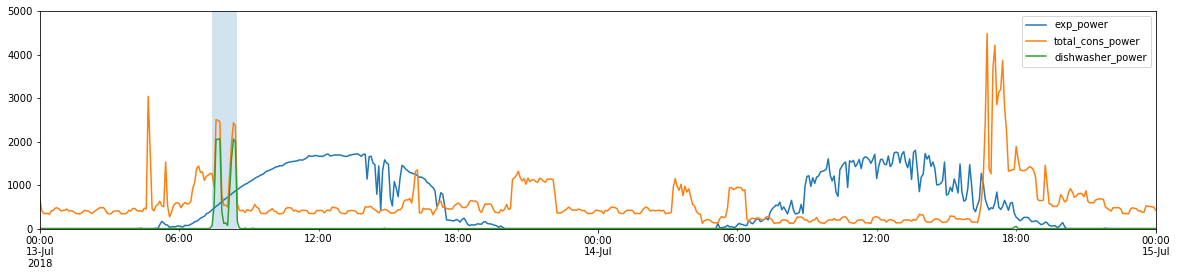

In [335]:
active_area = washes_df[usefully_shiftable_mask].sample().iloc[0]
preview_area = (pd.Timestamp(active_area.start).floor('d'), pd.Timestamp(active_area.start).ceil('d') + pd.Timedelta(1, 'd'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area.start, active_area.end, alpha=0.2)

# Calculate PV self-consumption

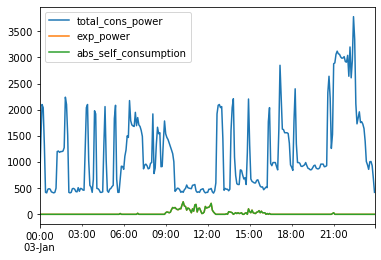

In [336]:
self_consumption_df = input_df.assign(abs_self_consumption=input_df[['total_cons_power', 'exp_power']].min(axis=1))
test_day_df = self_consumption_df['2018-01-03']
test_day_df[['total_cons_power', 'exp_power', 'abs_self_consumption']].plot()

In [337]:
print('Self-consumption for example day: {:.2f}%'.format(100 * test_day_df.abs_self_consumption.sum() / test_day_df.exp_power.sum()))
print('Self-consumption for all days: {:.2f}%'.format(100 * self_consumption_df.abs_self_consumption.sum() / self_consumption_df.exp_power.sum()))

Self-consumption for example day: 100.00%
Self-consumption for all days: 46.18%


[]

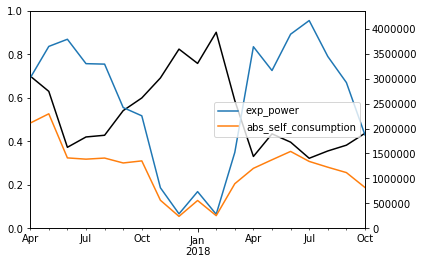

In [338]:
grouped = self_consumption_df.groupby(pd.Grouper(freq='M')).sum()

fig, ax1 = plt.subplots()
ax1.set_ylim(0, 1)
(grouped.abs_self_consumption / grouped.exp_power).plot(ax=ax1, color='black')
grouped[['exp_power', 'abs_self_consumption']].plot(ax=ax1.twinx(), ylim=0)
plt.plot()

In [339]:
def calc_self_consumption(df, consumed_column='total_cons_power', produced_column='exp_power'):
    return df[[consumed_column, produced_column]].min(axis=1).sum() / df[produced_column].sum()

print('Self-consumption for all days (using helper function): {:.2f}%'.format(100 * calc_self_consumption(input_df)))

Self-consumption for all days (using helper function): 46.18%


# Shift a single chunk of load

In [340]:
test_day_df = input_df[test_day]
active_area = (pd.Timestamp(test_day + ' 08:40:00'), pd.Timestamp(test_day + ' 10:00:00'))

In [341]:
def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))
    p.axvspan(active_area[0], active_area[1], alpha=0.2)

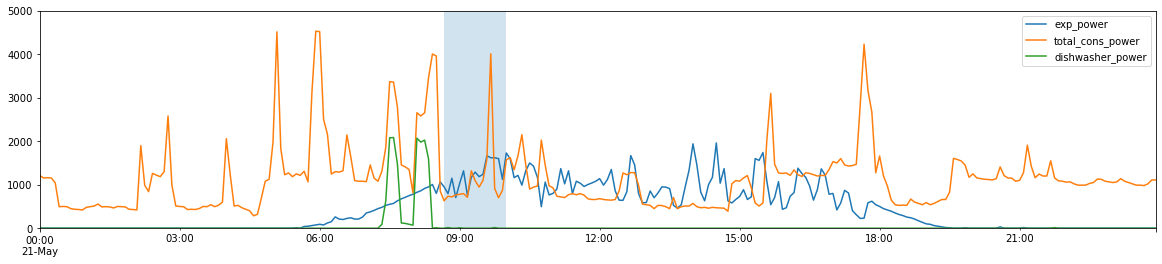

In [342]:
temp_plot(test_day_df)

In [343]:
active_mask = (test_day_df.index >= active_area[0]) & (test_day_df.index <= active_area[1])
print('Active for {} of {} periods'.format(active_mask.sum(), len(active_mask)))

Active for 17 of 288 periods


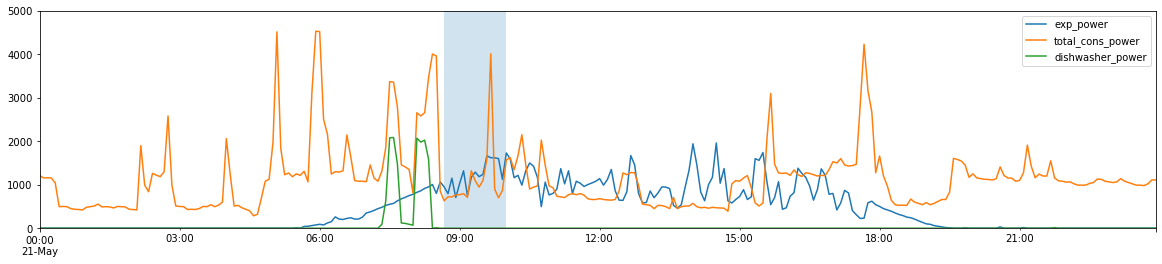

In [344]:
modified_df = test_day_df.copy()
modified_df.loc[active_mask, 'total_cons_power'] -= test_day_df[appliance_column]
modified_df.loc[active_mask, appliance_column] = 0
temp_plot(modified_df)

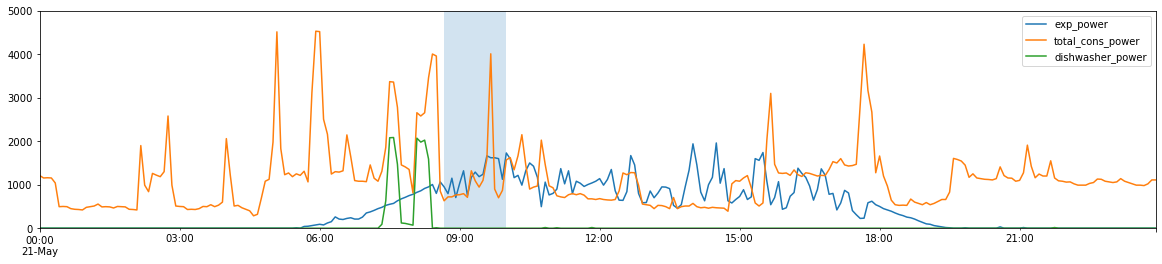

In [345]:
shifted = test_day_df.loc[active_mask, appliance_column].tshift(periods=25)
modified_df[appliance_column] = modified_df[appliance_column].add(shifted, fill_value=0)
modified_df.total_cons_power = modified_df.total_cons_power.add(shifted, fill_value=0)
temp_plot(modified_df)

In [346]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(100 * calc_self_consumption(test_day_df), 100 * calc_self_consumption(modified_df)))

Self-consumption improved from 79.72% to 79.71%


# Shift all load in a naive way
Move every wash to start at midday (on the same day), or to finish right before the next wash (whatever is earlier)

In [347]:
temp = np.maximum(washes_df.start, washes_df.start.dt.floor('D') + pd.Timedelta(12, 'hours'))
temp = np.minimum(washes_df.trailing_gap, temp - washes_df.start) / input_df.index.freq
shift_df = washes_df.assign(shift_periods=np.floor(temp).astype('int32'))

In [348]:
print("{} of {} washes will be shifted".format((shift_df.shift_periods > 0).sum(), len(shift_df)))

116 of 231 washes will be shifted


In [349]:
def apply_shift(df, shift_df, total_column, appliance_column):
    df = df.copy()
    for row in shift_df.itertuples():
        if not row.shift_periods:
            continue
        active_mask = (df.index >= row.start) & (df.index <= row.end)
        shifted = df.loc[active_mask, appliance_column].tshift(periods=row.shift_periods)
        df.loc[active_mask, total_column] -= df[appliance_column]
        df.loc[active_mask, appliance_column] = 0
        df[appliance_column] = df[appliance_column].add(shifted, fill_value=0)
        df[total_column] = df[total_column].add(shifted, fill_value=0)
    return df

In [350]:
modified_df = apply_shift(input_df, shift_df, 'total_cons_power', appliance_column)

In [351]:
print(*(d[appliance_column].sum() for d in [input_df, modified_df]))

3102720.0 3102720.0


In [352]:
test_day_df = input_df[test_day]
test_day_modified_df = modified_df[test_day]

def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))

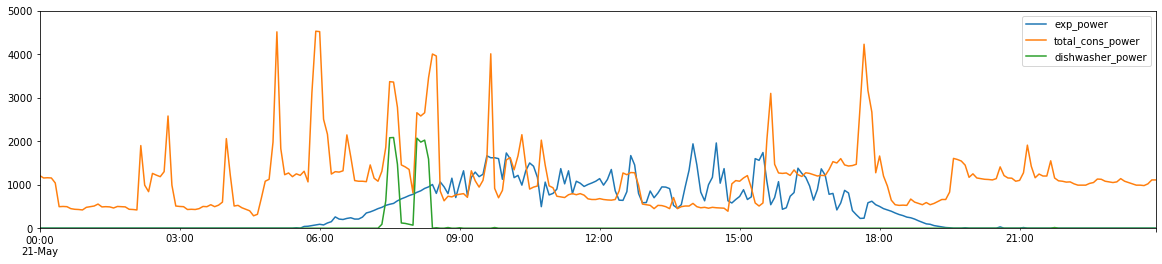

In [353]:
temp_plot(test_day_df)

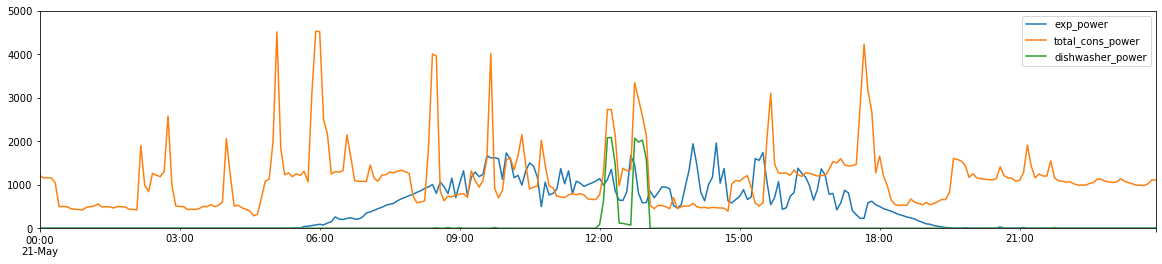

In [354]:
temp_plot(test_day_modified_df)

In [355]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(*(100 * calc_self_consumption(d) for d in [input_df, modified_df])))

Self-consumption improved from 46.18% to 46.83%


c:\bosser_workspace\scc\load-shifting-potential\venv\lib\site-packages\pandas\core\arrays\datetimelike.py:1213: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


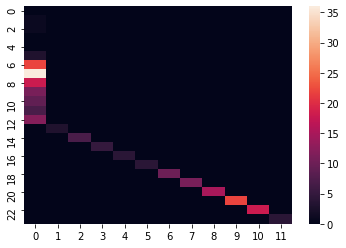

In [356]:
def time_in_hours(pd_datetime_series):
    return (pd_datetime_series - pd_datetime_series.dt.floor('D')).astype('timedelta64[h]')

temp = np.histogram2d(
    time_in_hours(shift_df.start),
    time_in_hours(shift_df.start + (shift_df.shift_periods * input_df.index.freq)),
    bins=[24,12],
    range=((0, 23), (12, 23))
)[0]
sns.heatmap(temp)

Shifted by 0 days 05:00:00


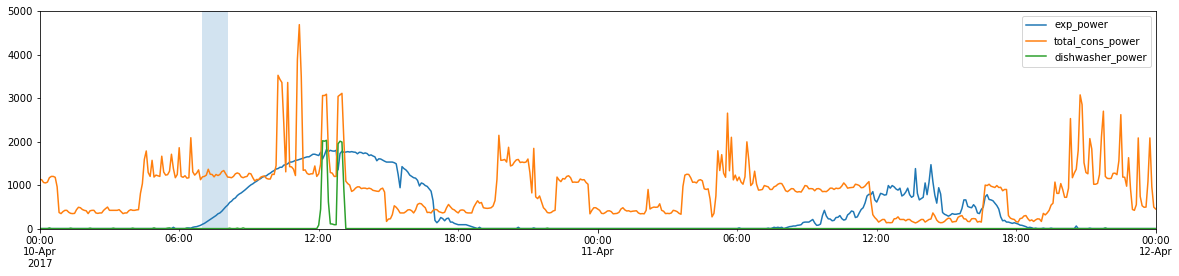

In [357]:
active_area = shift_df.sample().iloc[0]
if active_area.shift_periods:
    print('Shifted by {}'.format(pd.to_timedelta(active_area.shift_periods * input_df.index.freq)))
else:
    print('Not shifted')
preview_area = (pd.Timestamp(active_area.start).floor('d'), pd.Timestamp(active_area.start).ceil('d') + pd.Timedelta(1, 'd'))
p = modified_df.loc[preview_area[0]:preview_area[1], ['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)

# Upper bound for improvement
Calculate an upper bound for the self-consumption we can achieve by load-shifting an appliance. Just assume that any power used by the appliance will be self consumed.

In [358]:
def calc_self_consumption_bound(df, consumed_column='total_cons_power', produced_column='exp_power', appliance_columns=all_appliance_columns):
    df = df.copy()
    consumed_by_appliances = df[appliance_columns].sum().sum()
    df[consumed_column] -= df[appliance_columns].sum(axis=1)
    df[appliance_columns] = 0
    return (df[[consumed_column, produced_column]].min(axis=1).sum() + consumed_by_appliances) / df[produced_column].sum()

def calc_self_consumption_bound(df, appliance_column, consumed_column='total_cons_power', produced_column='exp_power'):
    df = df.copy()
    consumed_by_appliance = df[appliance_column].sum()
    df[consumed_column] -= df[appliance_column]
    df[appliance_column] = 0
    return (df[[consumed_column, produced_column]].min(axis=1).sum() + consumed_by_appliance) / df[produced_column].sum()

In [359]:
print("Self-consumption was {:.2f}% and the upper bound is {:.2f}%".format(
    100 * calc_self_consumption(input_df),
    100 * calc_self_consumption_bound(input_df,'dishwasher_power'),
))

Self-consumption was 46.18% and the upper bound is 52.26%


# educated shift

In [360]:
test_day_df = input_df[test_day]
active_area = (pd.Timestamp(test_day + ' 08:40:00'), pd.Timestamp(test_day + ' 10:00:00'))

In [361]:
def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))
    p.axvspan(active_area[0], active_area[1], alpha=0.2)

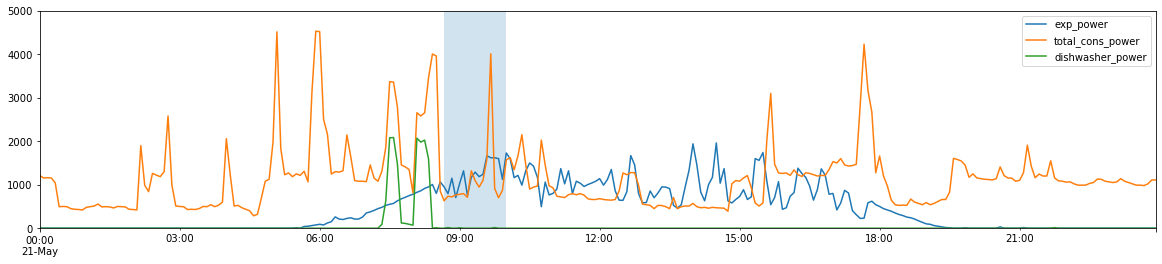

In [362]:
temp_plot(test_day_df)

In [363]:
active_mask = (test_day_df.index >= active_area[0]) & (test_day_df.index <= active_area[1])
print('Active for {} of {} periods'.format(active_mask.sum(), len(active_mask)))

Active for 17 of 288 periods


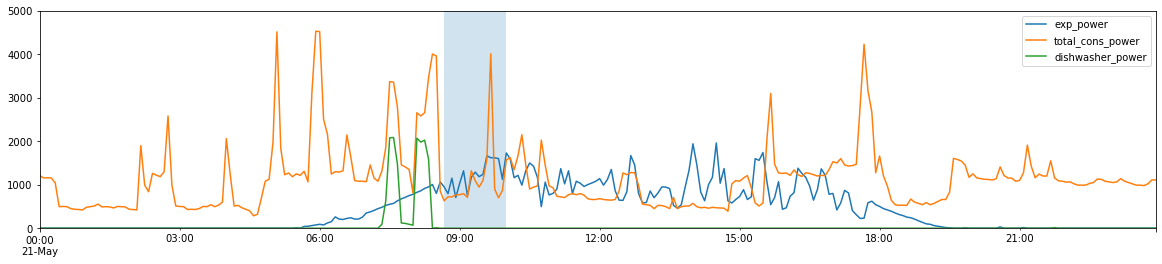

In [364]:
modified_df = test_day_df.copy()
modified_df.loc[active_mask, 'total_cons_power'] -= test_day_df[appliance_column]
modified_df.loc[active_mask, appliance_column] = 0
temp_plot(modified_df)

In [365]:
search_mask = (test_day_df.index >= active_area[0] & (test_day_df.index <= pd.Timestamp(active_area[0]).ceil('d') + pd.Timedelta(1, 'd'))

SyntaxError: unexpected EOF while parsing (<ipython-input-365-5ad0fe866dad>, line 1)

In [ ]:
unused_pv = test_day_df['exp_power'] - test_day_df['total_cons_power']
unused_pv.loc[unused_pv<0]=0

In [ ]:
np.correlate(unused_pv.loc[search_mask],test_day_df[appliance_column][active_mask]).argmax()

In [ ]:
shifted = test_day_df.loc[active_mask, appliance_column].tshift(periods=70)
modified_df[appliance_column] = modified_df[appliance_column].add(shifted, fill_value=0)
modified_df.total_cons_power = modified_df.total_cons_power.add(shifted, fill_value=0)
temp_plot(modified_df)

In [ ]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(100 * calc_self_consumption(test_day_df), 100 * calc_self_consumption(modified_df)))

### shift all appliances

In [366]:
temp = np.maximum(washes_df.start, washes_df.start.dt.floor('D') + pd.Timedelta(12, 'hours'))
temp = np.minimum(washes_df.trailing_gap, temp - washes_df.start) / input_df.index.freq
shift_df = washes_df.assign(shift_periods=np.floor(temp).astype('int32'))

In [367]:
search_ends = np.minimum(washes_df.end+washes_df.trailing_gap, washes_df.start.dt.floor('D') + pd.Timedelta(12, 'hours'))
unused_pv = input_df['exp_power'] - input_df['total_cons_power']
unused_pv.loc[unused_pv<0]=0

In [518]:
def get_educated_forward_shifts(df, actions_df, appliance_column, total_column='total_cons_power',exp_column='exp_power'):
    search_ends = np.minimum(actions_df.end+actions_df.trailing_gap, actions_df.start.dt.floor('D') + pd.Timedelta(24, 'hours'))
    unused_pv = df[exp_column] - df[total_column]
    unused_pv.loc[unused_pv<0]=0
    serch_df = actions_df.assign(search_end=search_ends)
    shifts = []
    for row in serch_df.itertuples():
        search_mask = (df.index >= row.start) & (df.index <= row.search_end)
        active_mask = (df.index >= row.start) & (df.index <= row.end)
        shifts.append(np.correlate(unused_pv.loc[search_mask],df[appliance_column][active_mask]).argmax())
    return pd.Series(shifts)
def get_educated_shifts(df, actions_df, appliance_column, total_column='total_cons_power',exp_column='exp_power'):
    search_ends = np.minimum(actions_df.end+actions_df.trailing_gap, actions_df.start.dt.floor('D') + pd.Timedelta(24, 'hours'))
    unused_pv = df[exp_column] - df[total_column]
    unused_pv.loc[unused_pv<0]=0
    serch_df = actions_df.assign(search_end=search_ends)
    shifts = []
    new_end = df.index[0]
    for row in serch_df.itertuples():
        search_start = np.maximum(new_end,row.start.floor('D'))
        search_mask = (df.index >= search_start) & (df.index <= row.search_end)
        active_mask = (df.index >= row.start) & (df.index <= row.end)
        shift = np.correlate(unused_pv.loc[search_mask],df[appliance_column][active_mask]).argmax()
        if shift != 0:
            shift = (shift + (search_start-row.start)/df.index.freq).astype('int32')
        shifts.append(shift)
        new_end = row.end+pd.Timedelta(shift*df.index.freq)
    return pd.Series(shifts)

In [521]:
shift_df = washes_df.assign(shift_periods=get_educated_shifts(input_df,washes_df,'dishwasher_power'))

In [523]:
print("{} of {} washes will be shifted".format((shift_df.shift_periods > 0).sum(), len(shift_df)))

91 of 231 washes will be shifted


In [524]:
modified_df = apply_shift(input_df, shift_df, 'total_cons_power', appliance_column)

In [525]:
print(*(d[appliance_column].sum() for d in [input_df, modified_df]))

3102720.0 3102720.0


In [526]:
def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))

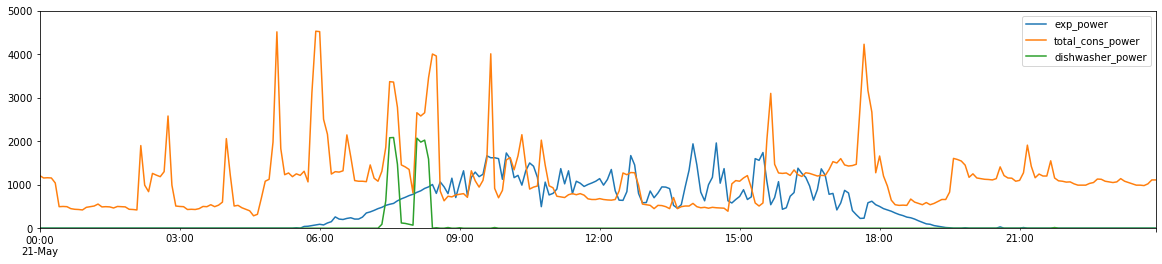

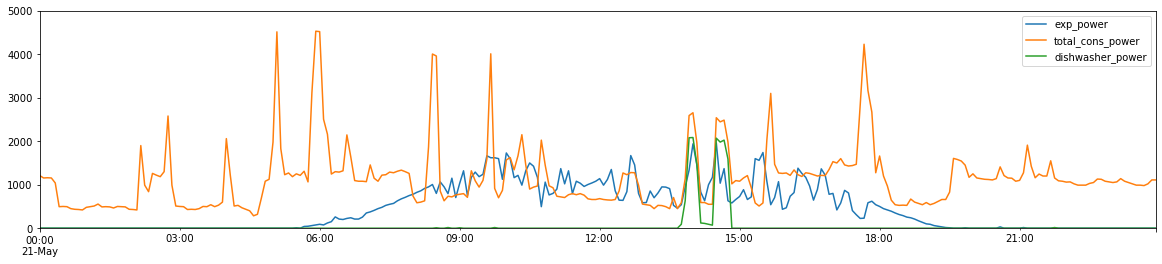

In [527]:
test_day = '2017-05-21'
test_day_df = input_df[test_day]
test_day_modified_df = modified_df[test_day]
temp_plot(test_day_df)
temp_plot(test_day_modified_df)

In [528]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(*(100 * calc_self_consumption(d) for d in [input_df, modified_df])))

Self-consumption improved from 46.18% to 48.24%


c:\bosser_workspace\scc\load-shifting-potential\venv\lib\site-packages\pandas\core\arrays\datetimelike.py:1213: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


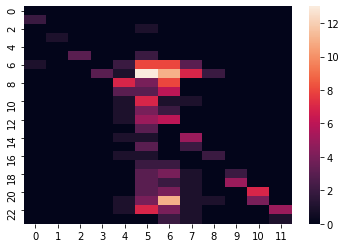

In [529]:
def time_in_hours(pd_datetime_series):
    return (pd_datetime_series - pd_datetime_series.dt.floor('D')).astype('timedelta64[h]')

temp = np.histogram2d(
    time_in_hours(shift_df.start),
    time_in_hours(shift_df.start + (shift_df.shift_periods * input_df.index.freq)),
    bins=[24,12],
    range=((0, 23), (0, 23))
)[0]
sns.heatmap(temp)